In [13]:
from keras.preprocessing import image_dataset_from_directory
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, RandomElasticTransform, RandomRotation, RandomZoom
from keras.models import Sequential
import numpy as np

In [14]:
data: tf.data.Dataset = image_dataset_from_directory(
    "notes/training", color_mode="grayscale", image_size=(64, 64)
)
class_names = data.class_names

augmentation = Sequential([
    RandomRotation(0.1),
    RandomZoom(0.1),
    RandomElasticTransform(0.1)
])

def augment_images(image, label):
    image = augmentation(image)
    return image, label

data = data.map(augment_images)

Found 4000 files belonging to 5 classes.


Labels in batch: [2 2 3 3 0 0 0 1 3 0 4 3 4 1 3 4 3 1 1 2 2 3 0 3 2 2 3 3 1 2 2 2]


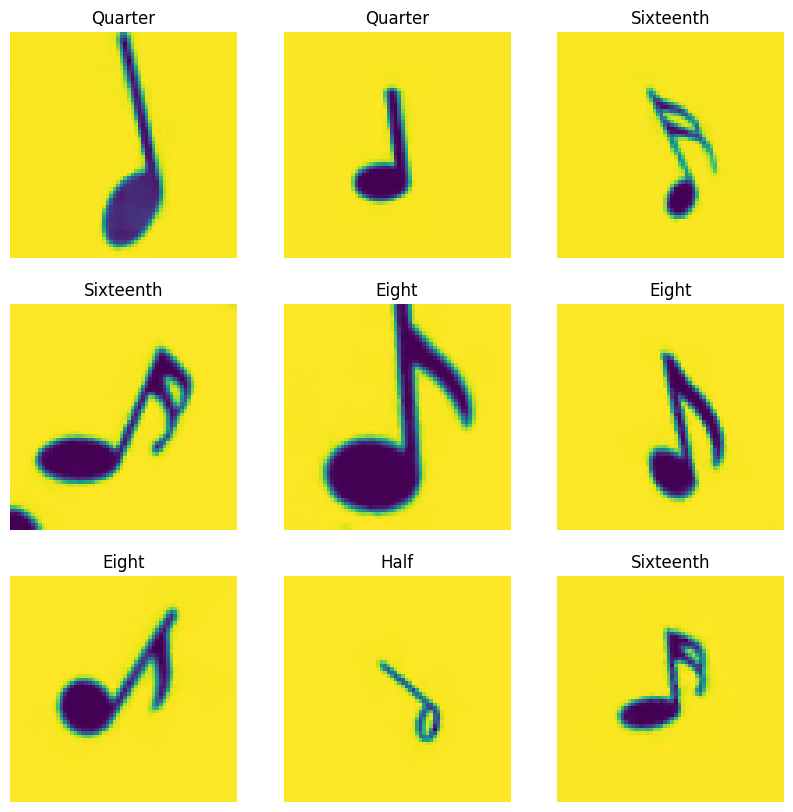

In [15]:
for images, labels in data.take(1):
    print("Labels in batch:", labels.numpy())
    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
    plt.show()

In [25]:
model = Sequential(
    [
        Conv2D(
            8, kernel_size=3, padding="same", activation="relu", input_shape=(64, 64, 1)
        ),
        MaxPooling2D(2, 2),
        Conv2D(16, kernel_size=3, padding="same", activation="relu"),
        MaxPooling2D(2, 2),
        Conv2D(32, kernel_size=3, padding="same", activation="relu"),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(64, activation="relu"),
        Dense(5, activation="softmax"),
    ]
)

model.summary()

/home/printchard/workspace/tc3002b/ml-note-detection/venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 64, 64, 8)      │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 32, 32, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 32, 32, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 16, 16, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 16, 16, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │       131,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 137,349 (536.52 KB)

 Trainable params: 137,349 (536.52 KB)

 Non-trainable params: 0 (0.00 B)

In [26]:
train_dataset = data.prefetch(buffer_size=tf.data.AUTOTUNE)
def scale_images(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

train_dataset = train_dataset.map(scale_images)

In [27]:
model.compile(
    optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

total_batches = tf.data.experimental.cardinality(train_dataset).numpy()
val_batches = int(0.2 * total_batches)

val_dataset = train_dataset.take(val_batches)
actual_train_dataset = train_dataset.skip(val_batches)

history = model.fit(
    actual_train_dataset,
    epochs=15,
    validation_data=val_dataset
)

Epoch 1/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.3247 - loss: 1.5018 - val_accuracy: 0.5913 - val_loss: 1.0667
Epoch 2/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6395 - loss: 0.9297 - val_accuracy: 0.7500 - val_loss: 0.8189
Epoch 3/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7770 - loss: 0.7037 - val_accuracy: 0.8288 - val_loss: 0.5695
Epoch 4/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8436 - loss: 0.5506 - val_accuracy: 0.8500 - val_loss: 0.5482
Epoch 5/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8732 - loss: 0.4918 - val_accuracy: 0.9062 - val_loss: 0.4627
Epoch 6/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9028 - loss: 0.4120 - val_accuracy: 0.8963 - val_loss: 0.3748
Epoch 7/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9100 - loss: 0.4157 - val_accuracy: 0.9062 - val_loss: 0.3910
Epoch 8/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9183 - loss: 0.3564 - val_accu

In [28]:
test_data: tf.data.Dataset = image_dataset_from_directory(
    "notes/test", color_mode="grayscale", image_size=(64, 64)
)

test_dataset = test_data.prefetch(buffer_size=tf.data.AUTOTUNE)
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test loss: {test_loss}")
print(f"Test accuracy: {test_accuracy}")

Found 1000 files belonging to 5 classes.
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9905 - loss: 0.8705 
Test loss: 1.06607186794281
Test accuracy: 0.9869999885559082


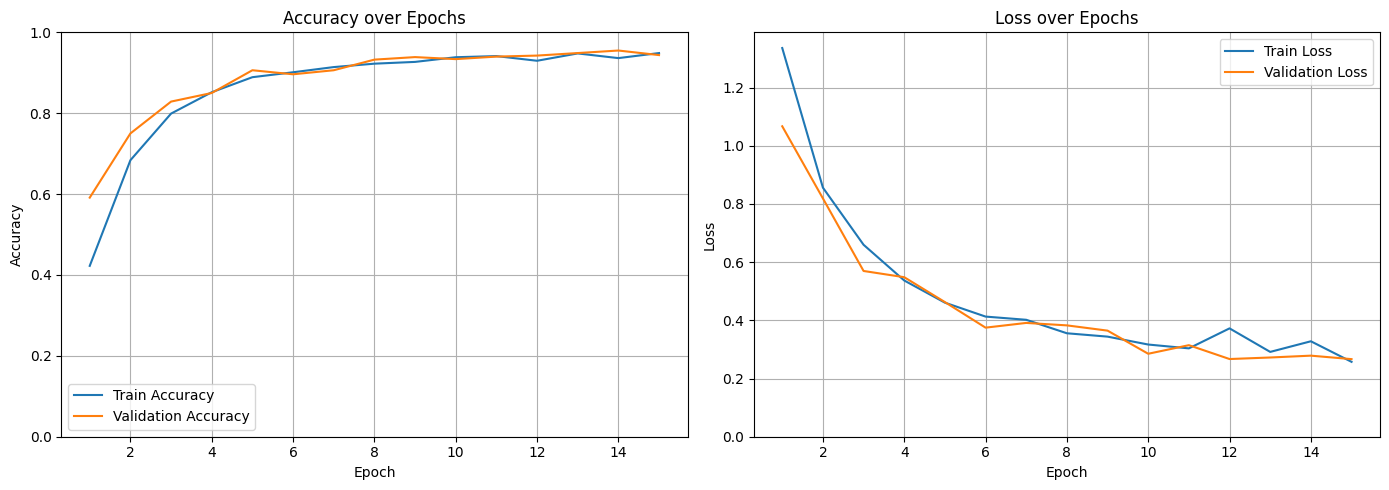

In [29]:
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

epochs = range(1, len(history.history['accuracy']) + 1)
train_acc = history.history['accuracy']
train_loss = history.history['loss']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy plot
ax1.plot(epochs, train_acc, label='Train Accuracy')
ax1.plot(epochs, val_acc, label='Validation Accuracy')
ax1.set_title('Accuracy over Epochs')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.set_ylim(0, 1)
ax1.legend()
ax1.grid(True)

# Loss plot
ax2.plot(epochs, train_loss, label='Train Loss')
ax2.plot(epochs, val_loss, label='Validation Loss')
ax2.set_title('Loss over Epochs')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.set_ylim(0, ax2.get_ylim()[1])
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


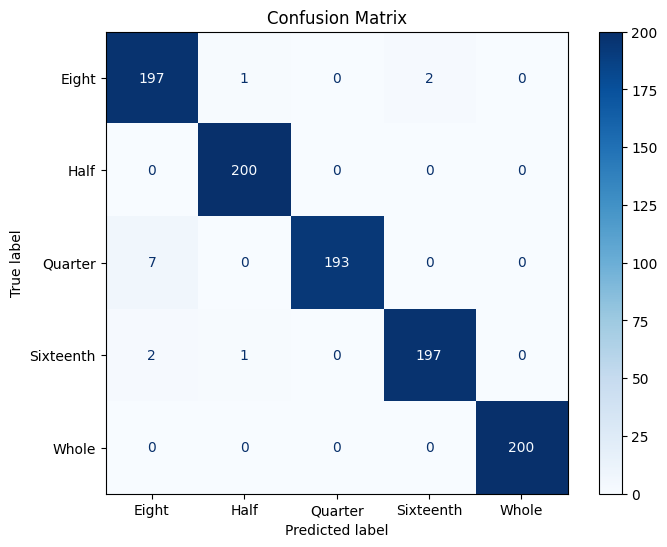

In [30]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

all_images = []
all_labels = []
for images, labels in test_data:
    all_images.append(images)
    all_labels.append(labels)
X_test = np.concatenate(all_images)
y_true = np.concatenate(all_labels)


pred_probs = model.predict(X_test)
y_pred = np.argmax(pred_probs, axis=1)

cm = confusion_matrix(y_true, y_pred)

fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(ax=ax, cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

In [31]:
recall_per_class = np.diag(cm) / np.sum(cm, axis=1)
for idx, recall in enumerate(recall_per_class):
    print(f"Recall for class '{class_names[idx]}': {recall:.2f}")

Recall for class 'Eight': 0.98
Recall for class 'Half': 1.00
Recall for class 'Quarter': 0.96
Recall for class 'Sixteenth': 0.98
Recall for class 'Whole': 1.00


In [32]:
from sklearn.metrics import precision_score

precision_per_class = precision_score(y_true, y_pred, average=None)
for idx, precision in enumerate(precision_per_class):
    print(f"Precision for class '{class_names[idx]}': {precision:.2f}")

macro_precision = precision_score(y_true, y_pred, average='macro')
print(f"Macro-averaged precision: {macro_precision:.2f}")

Precision for class 'Eight': 0.96
Precision for class 'Half': 0.99
Precision for class 'Quarter': 1.00
Precision for class 'Sixteenth': 0.99
Precision for class 'Whole': 1.00
Macro-averaged precision: 0.99


In [33]:
model.save_weights('note_detection.weights.h5')